# Predictive analysis using Facebook Prophet and Olive™ EdgeROS

## Introduction
In this project, a ROS (Robot Operating System) node is employed, which subscribes to a topic that continuously publishes acceleration values. These values, reflective of the machine's activity, are meticulously logged into a CSV file, ensuring data integrity even after the node is shut down. This stored dataset serves as the foundational training data for the Prophet algorithm.

By leveraging this dataset, Prophet—an open-source forecasting tool—becomes empowered to discern patterns and forecast future trends based on past acceleration values. This proactive approach allows for predictive maintenance strategies, enabling preemptive interventions to mitigate potential issues before they escalate.

Through seamless integration with ROS, this system not only ensures the real-time monitoring of machine health but also facilitates the efficient utilization of historical data to optimize predictive maintenance efforts. This holistic approach embodies the convergence of robotics, data analytics, and predictive maintenance methodologies to enhance operational efficiency and minimize downtime.

### Loading of data from a CSV file

In [1]:
import os
#os.chdir('')
print(" Current Working Directory")
%pwd

 Current Working Directory


'/home/ninad/AkzentE4.0/jupyternotebook'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [4]:
data_dir = './data_new'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    
    # Check if the current item is a file
    if os.path.isfile(file_path):
        dataset = pd.read_csv(file_path, header=0, index_col=[0])
        merged_data = merged_data.append(dataset)

print(merged_data)

                     Acceleration
Timestamp                        
2024-05-11 20:35:19      1.698617
2024-05-11 20:35:20      1.028300
2024-05-11 20:35:21      1.430280
2024-05-11 20:35:23      1.221188
2024-05-11 20:35:24      1.774119
...                           ...
2024-05-11 20:38:17      8.564718
2024-05-11 20:38:18     13.438575
2024-05-11 20:38:19      7.126149
2024-05-11 20:38:20      8.416068
2024-05-11 20:38:21      4.196832

[175 rows x 1 columns]


Checking the begining and the end of Data

In [5]:
merged_data.head()

,Acceleration
Timestamp,
2024-05-11 20:35:19,1.698617
2024-05-11 20:35:20,1.028300
2024-05-11 20:35:21,1.430280
2024-05-11 20:35:23,1.221188
2024-05-11 20:35:24,1.774119


In [6]:
merged_data.tail()

,Acceleration
Timestamp,
2024-05-11 20:38:17,8.564718
2024-05-11 20:38:18,13.438575
2024-05-11 20:38:19,7.126149
2024-05-11 20:38:20,8.416068
2024-05-11 20:38:21,4.196832


Checking total points

In [7]:
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 176


### Visualising the Data

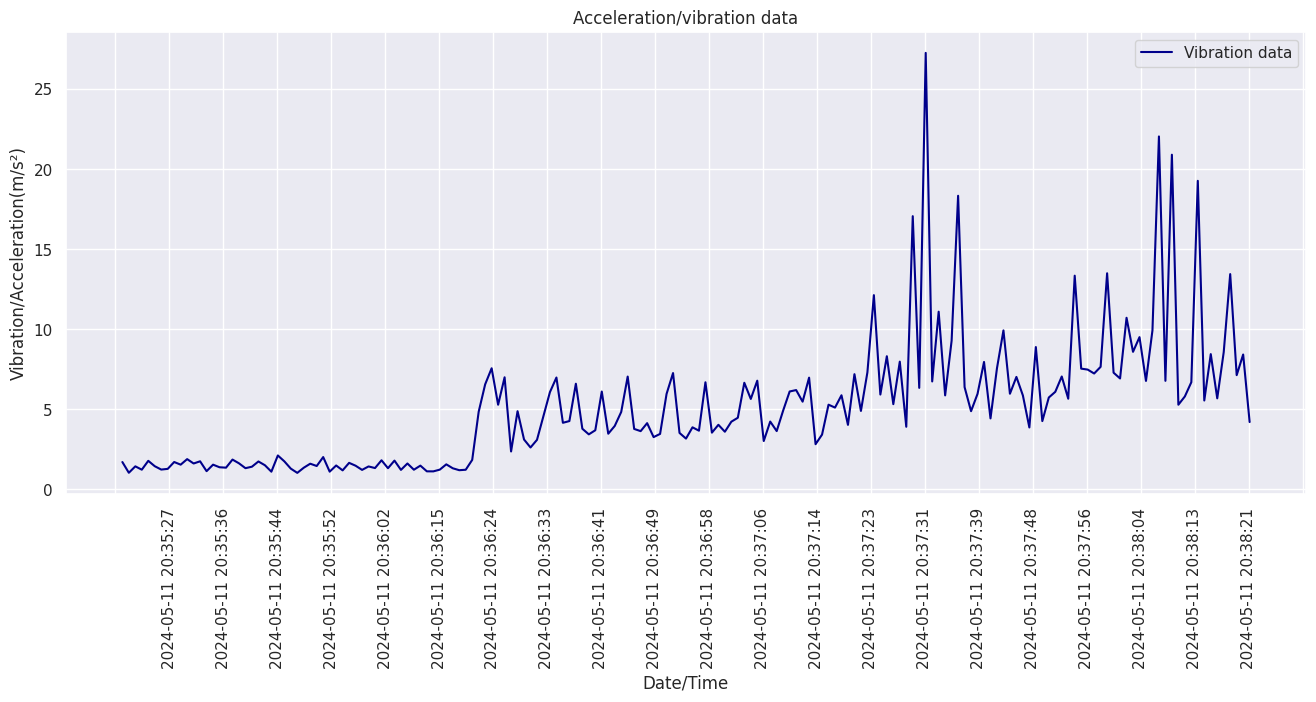

In [49]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=merged_data, x='Timestamp', y='Acceleration', label='Vibration data', color='darkblue')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=200)) # Set interval higher if more data points
plt.xticks(rotation=90)
plt.title('Acceleration/vibration data')
plt.xlabel('Date/Time')
plt.ylabel('Vibration/Acceleration(m/s²)')
plt.legend()
plt.show()

### Zooming in the data

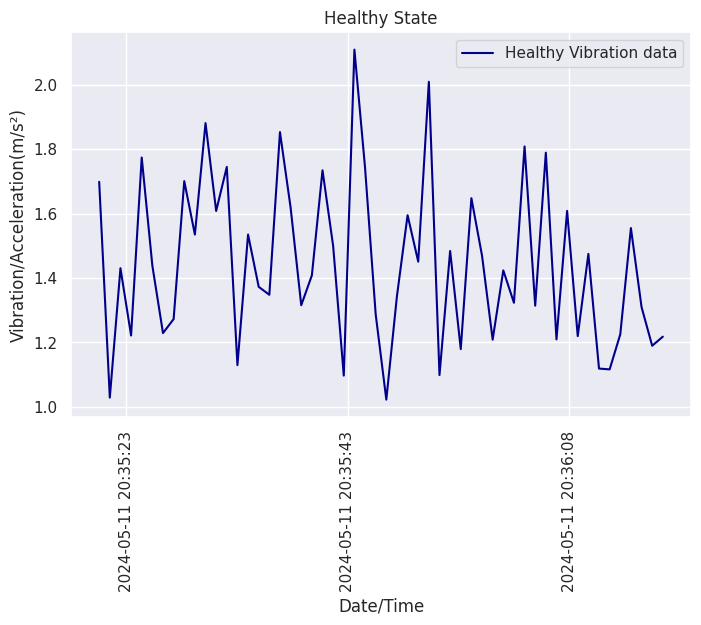

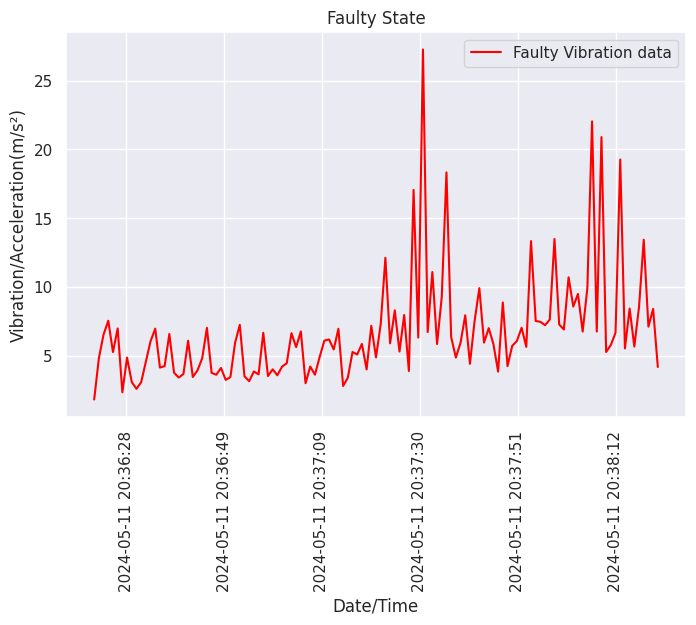

In [50]:
healthy = merged_data['2024-05-11 20:35:19' : '2024-05-11 20:36:20'] # Healty dataset
faulty = merged_data['2024-05-11 20:36:21' : '2024-05-11 20:38:21'] # faulty dataset

# Zooming on healthy data
plt.figure(figsize=(8, 5))
sns.lineplot(data=healthy, x='Timestamp', y='Acceleration', label='Healthy Vibration data', color='darkblue')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=500)) # Set interval higher if more data points
plt.xticks(rotation=90)
plt.title('Healthy State')
plt.xlabel('Date/Time')
plt.ylabel('Vibration/Acceleration(m/s²)')

# Zooming on faulty data
plt.figure(figsize=(8,5))
sns.lineplot(data=faulty, x='Timestamp', y='Acceleration', label='Faulty Vibration data', color='red')
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=500)) # Set interval higher if more data points
plt.xticks(rotation=90)
plt.title('Faulty State')
plt.xlabel('Date/Time')
plt.ylabel('Vibration/Acceleration(m/s²)')

plt.legend()
plt.show()

### Anamoly detection using Prophet

Detecting anomalies in time series data involves identifying data points that deviate significantly from the expected or normal behavior of the system under observation. This is particularly important in machine health monitoring, where unexpected spikes or shifts in the data can indicate potential issues or deterioration in the machine's performance.

The task involves identifying outliers in the time series data that may signify anomalies such as sudden increases in vibration levels or persistent shifts in operational parameters. By analyzing deviations from the typical patterns of the machine's behavior, we can proactively identify potential issues before they escalate, enabling timely maintenance or intervention to prevent downtime or damage.

This approach to anomaly detection in time series data is crucial for ensuring the reliability, efficiency, and longevity of machines and equipment in various industrial and operational settings.

### Prophet:
Prophet is a versatile tool for time series forecasting, leveraging an additive model to capture non-linear trends and various seasonal patterns like yearly, weekly, and daily effects, alongside holiday impacts. It excels particularly in datasets showcasing pronounced seasonal variations and encompasses extensive historical data across multiple seasons. One of Prophet's notable strengths lies in its resilience to missing data and its ability to adapt to shifts in trends. Additionally, it demonstrates robust performance in handling outliers effectively. This makes Prophet a valuable asset for forecasting tasks across diverse domains, facilitating accurate predictions even in the presence of irregularities or abrupt changes in the data.

In [51]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

### Training data set
During the training phase of the anomaly detection model, data from the healthy phase of the bearing is utilized. When employing Prophet for this purpose, the input data should adhere to a specific format. It should be structured as a dataframe with two columns:

* ds (datestamp): This column should contain the timestamps corresponding to the measurements. The timestamps should ideally be in the format expected by Pandas, such as 'YYYY-MM-DD' for a date or 'YYYY-MM-DD HH:MM:SS' for a timestamp.

* y: This column should contain numeric values representing the measurements that we aim to forecast or analyze. These could be vibration levels, temperature readings, or any other relevant metrics indicative of the machine's health.

By adhering to this format, Prophet can effectively analyze the time series data and generate forecasts, facilitating the detection of anomalies or deviations from the expected behavior during the healthy phase of the bearing.

In [52]:
# Creating training dataframe
prophet_healthy_train = pd.DataFrame()
prophet_healthy_train['ds'] = healthy.index
prophet_healthy_train['y'] = healthy.values

Checking the beginning and the end of the Data

In [53]:
prophet_healthy_train.head()

,ds,y
0,2024-05-11 20:35:19,1.698617
1,2024-05-11 20:35:20,1.028300
2,2024-05-11 20:35:21,1.430280
3,2024-05-11 20:35:23,1.221188
4,2024-05-11 20:35:24,1.774119


In [54]:
prophet_healthy_train.tail()

,ds,y
49,2024-05-11 20:36:15,1.224867
50,2024-05-11 20:36:16,1.554895
51,2024-05-11 20:36:17,1.309580
52,2024-05-11 20:36:19,1.189412
53,2024-05-11 20:36:20,1.217580


## Creating the model: Calling the Prophet Module for training

In [55]:
m = Prophet(interval_width=1)
# Using healthy data for training
m.fit(prophet_healthy_train)

16:49:13 - cmdstanpy - INFO - Chain [1] start processing
16:49:13 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
forecast_healthy = m.predict(prophet_healthy_train)
forecast_healthy[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2024-05-11 20:35:19,1.536632,0.816810,2.329180
1,2024-05-11 20:35:20,1.533423,0.817662,2.393904
2,2024-05-11 20:35:21,1.530215,0.747281,2.327108
3,2024-05-11 20:35:23,1.523798,0.691333,2.304188
4,2024-05-11 20:35:24,1.520590,0.763390,2.418028


# Analysing the healthy data

Displaying Prophet plot
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


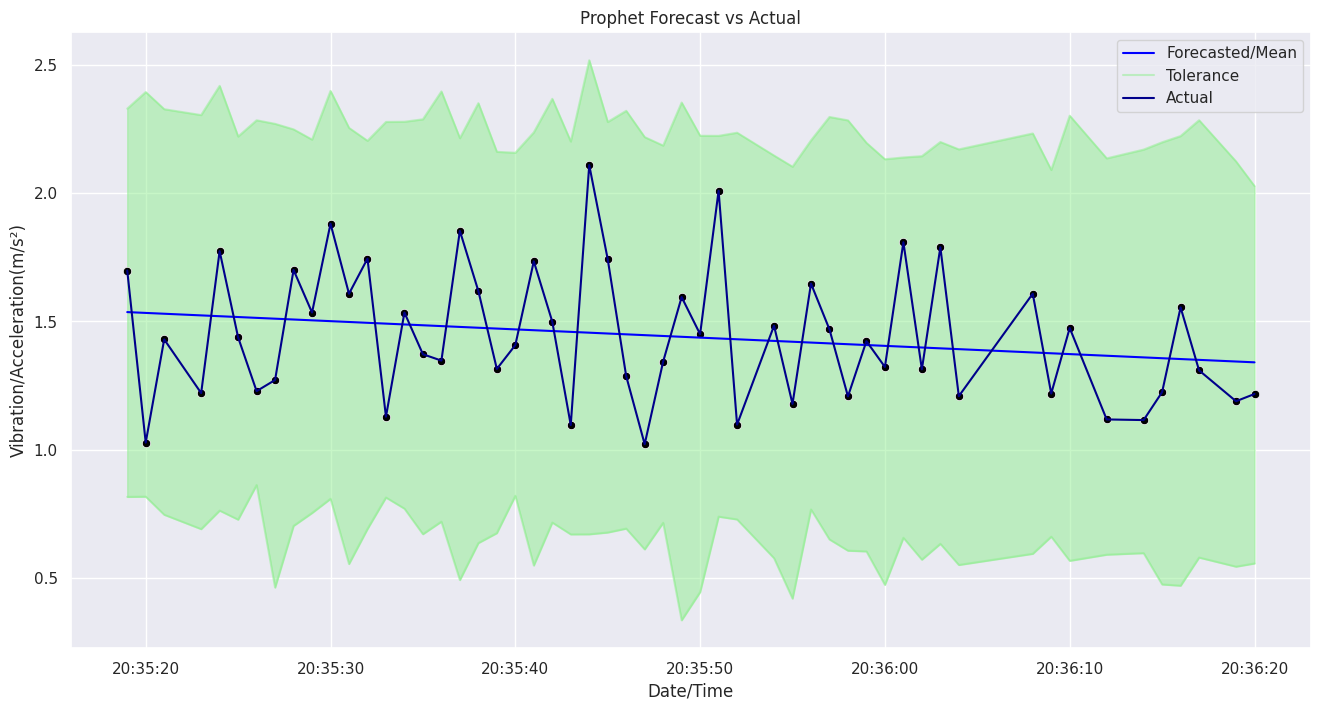

Black points are the true values from the IMU. Lightblue line is the trend line and the light green area is the tolerance.


In [64]:
forecast_healthy['fact'] = prophet_healthy_train['y'].reset_index(drop=True)
print('Displaying Prophet plot')

# Plotting the forecasted values
plt.figure(figsize=(16, 8))
sns.lineplot(data=forecast_healthy, x='ds', y='yhat', label='Forecasted/Mean', color='blue')

# Plotting the bounds
sns.lineplot(data=forecast_healthy, x='ds', y='yhat_lower', label='Tolerance', color='lightgreen', alpha=0.5)
sns.lineplot(data=forecast_healthy, x='ds', y='yhat_upper', color='lightgreen', alpha = 0.5)
plt.fill_between(forecast_healthy['ds'], forecast_healthy['yhat_lower'], forecast_healthy['yhat_upper'], color='lightgreen', alpha=0.5)

# Plotting the healthy values
sns.lineplot(data=forecast_healthy, x='ds', y='fact', label='Actual', color='darkblue')
sns.scatterplot(data=forecast_healthy, x='ds', y='fact', color='black')

#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2500))
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date/Time')
plt.ylabel('Vibration/Acceleration(m/s²)')
plt.legend()
plt.show()

print("Black points are the true values from the IMU. Lightblue line is the trend line and the light green area is the tolerance.")

### Analysis on test data

To assess the effectiveness of the previously developed model in detecting faulty machine conditions, we can employ the following approach:

* Prepare Test Data: Collect data representing faulty machine conditions. This data should be formatted similarly to the training data, with timestamps ('ds') and corresponding numeric measurements ('y').

* Utilize Trained Model: Apply the trained Prophet model to the test data containing faulty conditions. This involves inputting the test data into the model and generating forecasts based on the learned patterns from the healthy phase.

* Detect Anomalies: Analyze the model's predictions on the faulty test data. Look for instances where the predicted values deviate significantly from the actual measurements. These deviations could signify potential anomalies or indications of faulty machine behavior.

* Evaluate Model Performance: Assess the model's performance in detecting faulty conditions by calculating appropriate evaluation metrics. These metrics could include accuracy, precision, recall, or other measures tailored to the specific requirements of the task.

* Visualize Results: Plot the actual measurements alongside the model's predictions to visually inspect how well the model identifies faulty conditions. Visualization aids in understanding the model's behavior and identifying any areas for improvement.

By following this approach, we can systematically evaluate the model's capability to detect faulty machine conditions using unseen test data.

In [58]:
# Creating test dataframe
prophet_faulty_test = pd.DataFrame()
prophet_faulty_test['ds'] = faulty.index
prophet_faulty_test['y'] = faulty.values

Checking the beginning and the end of the Data

In [59]:
prophet_faulty_test.head()

,ds,y
0,2024-05-11 20:36:21,1.832676
1,2024-05-11 20:36:22,4.840021
2,2024-05-11 20:36:23,6.552503
3,2024-05-11 20:36:24,7.556282
4,2024-05-11 20:36:25,5.277973


In [60]:
prophet_faulty_test.tail()

,ds,y
116,2024-05-11 20:38:17,8.564718
117,2024-05-11 20:38:18,13.438575
118,2024-05-11 20:38:19,7.126149
119,2024-05-11 20:38:20,8.416068
120,2024-05-11 20:38:21,4.196832


In [61]:
forecast_faulty = m.predict(prophet_faulty_test)
forecast_faulty[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
116,2024-05-11 20:38:17,0.965538,-0.058781,1.820165
117,2024-05-11 20:38:18,0.962329,0.088305,1.825806
118,2024-05-11 20:38:19,0.959121,0.153837,1.750091
119,2024-05-11 20:38:20,0.955912,0.126647,1.920790
120,2024-05-11 20:38:21,0.952704,0.105632,1.795856


Displaying Prophet plot


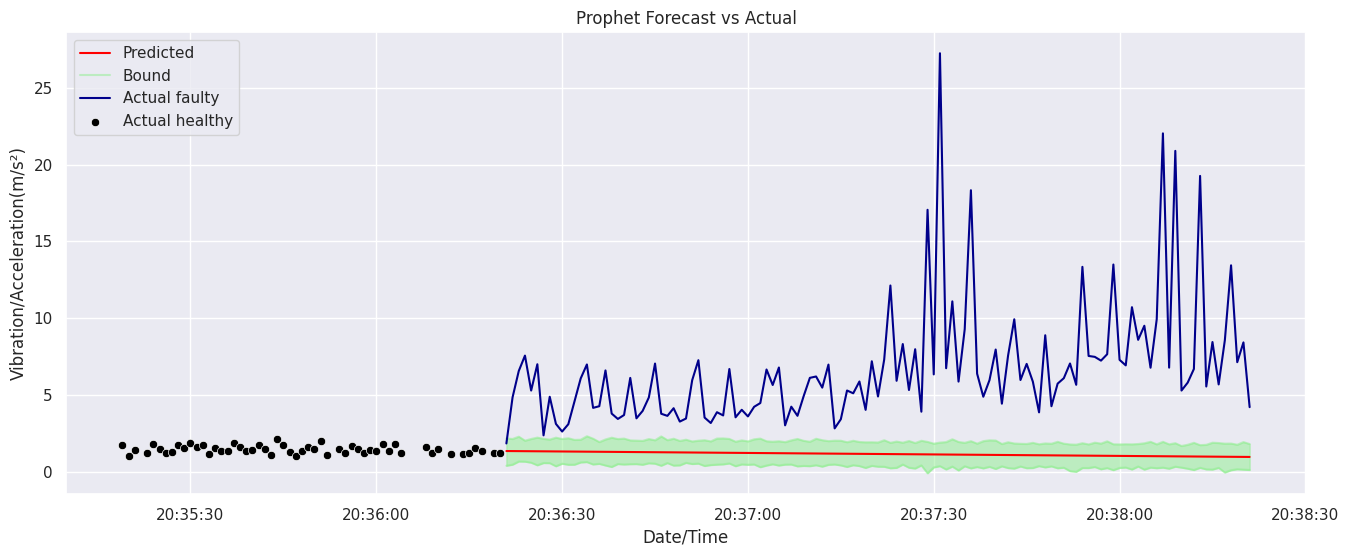

Black points are the actual healthy state values. Red line describes the expected values and light green area is the tolerance.


In [63]:
forecast_faulty['fact'] = prophet_faulty_test['y'].reset_index(drop = True)
print('Displaying Prophet plot')

# Plotting the forecasted values
plt.figure(figsize=(16, 6))
sns.lineplot(data=forecast_faulty, x='ds', y='yhat', label='Predicted', color='red')

# Plotting the bounds
sns.lineplot(data=forecast_faulty, x='ds', y='yhat_lower', label='Bound', color='lightgreen', alpha=0.5)
sns.lineplot(data=forecast_faulty, x='ds', y='yhat_upper', color='lightgreen', alpha=0.5)
plt.fill_between(forecast_faulty['ds'], forecast_faulty['yhat_lower'], forecast_faulty['yhat_upper'], color='lightgreen', alpha=0.5)

# Plotting the actual values
sns.lineplot(data=forecast_faulty, x='ds', y='fact', label='Actual faulty', color='darkblue')
sns.scatterplot(data=forecast_healthy, x='ds', y='fact', label='Actual healthy', color='black')

#plt.text(0.2, 0.25, 'actual healthy', horizontalalignment='left', verticalalignment='bottom', transform=plt.gca().transAxes, fontsize=12, color='blue')
plt.title('Prophet Forecast vs Actual')
plt.xlabel('Date/Time')
plt.ylabel('Vibration/Acceleration(m/s²)')
plt.legend()
plt.show()

print("Black points are the actual healthy state values. Red line describes the expected values and light green area is the tolerance.")

## Conclusion
By leveraging historical data on health trends and setting an acceptable variance parameter, a model can be trained to predict future trends and raise alarms if any significant deviation occurs. This predictive approach is not only applicable to individual health monitoring but also extends to analyzing multiple signals simultaneously to generate a comprehensive metric, such as a "health score" for machinery.

Implementing predictive maintenance strategies enables the early detection of potential issues, thereby reducing operational costs. Rather than relying on scheduled preventive maintenance routines that may disrupt operations, maintenance activities can be planned more efficiently. Predictive maintenance utilizes sensors, machine learning algorithms, and advanced analytics to identify faults and anticipate failures. Through integration with the Industrial Internet of Things (IIoT), access to historical data facilitates the development of statistical analyses and trend identification, providing insights into the root causes of problems and guiding appropriate actions.

## References
1. https://facebook.github.io/prophet/
2. https://www.olive-robotics.com/olive-imu